In [1]:
### Imports, some helper functions
import numpy as np
import xarray as xr
import glob
import os
import hashlib
import dask
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, FuncFormatter
from dask.distributed import Client, LocalCluster
import seaborn as sns
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pprint import pp
from datetime import date

# let's test for now...
from xarray_cacher import *

In [2]:
### Data loading
# Corrected lat-lon grid will be handled separately 
model_grid = xr.open_mfdataset("/data/ycheng46/NNA/data/alaska_climate_region.nc")
static_lat2d = model_grid.lat.values
static_lon2d = model_grid.lon.values % 360

# DAILY snow
snow_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/snow_m/*.nc",
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/snow_m/*.nc",
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/snow_m/*.nc" ]

rain_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/rain_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/rain_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/rain_m/*.nc" ]

temp_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/tsa_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/tsa_m/*.nc", 
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/tsa_m/*.nc" ]

better_h2osno_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/swe_d/*.nc",
                        "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/swe_d/*.nc",
                        "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/swe_d/*.nc" ]

qrunoff_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/qrunoff_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/qrunoff_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/qrunoff_m/*.nc" ]

snow_P, snow_H, snow_M = unpacker(snow_paths, "SNOW")
rain_P, rain_H, rain_M = unpacker(rain_paths, "RAIN")
temp_P, temp_H, temp_M = unpacker(temp_paths, "TSA")
better_h2osno_P, better_h2osno_H, better_h2osno_M = unpacker(better_h2osno_paths, "H2OSNO")
qrunoff_P, qrunoff_H, qrunoff_M = unpacker(qrunoff_paths, "QRUNOFF")

In [3]:
### Data editing
## Constants
seconds_per_year = 365.25 * 86400
seconds_per_season = 90.25 * 86400

## Helpers for our cache functions
def compute_annual_generic(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_annual_runoff(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_geo_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(2034, 2064))

def compute_geo_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(1990, 2020))

def compute_layer_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(2034, 2064))

def compute_layer_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(1990, 2020))
    
## Snow
total_snow_P = (snow_P) 
total_snow_H = (snow_H) 
total_snow_M = (snow_M)

#total_snow_P = (snow_P) * seconds_per_year
#total_snow_H = (snow_H) * seconds_per_year
#total_snow_M = (snow_M) * seconds_per_year

annual_snow_P = cache_xarray(compute_annual_generic, total_snow_P, name_hint="annual_snow_P")
annual_snow_H = cache_xarray(compute_annual_generic, total_snow_H, name_hint="annual_snow_H")
annual_snow_M = cache_xarray(compute_annual_generic, total_snow_M, name_hint="annual_snow_M")

## Rain
total_rain_P = (rain_P)
total_rain_H = (rain_H)
total_rain_M = (rain_M)

#total_rain_P = (rain_P) * seconds_per_year
#total_rain_H = (rain_H) * seconds_per_year
#total_rain_M = (rain_M) * seconds_per_year

annual_rain_P = cache_xarray(compute_annual_generic, total_rain_P, name_hint="annual_rain_P")
annual_rain_H = cache_xarray(compute_annual_generic, total_rain_H, name_hint="annual_rain_H")
annual_rain_M = cache_xarray(compute_annual_generic, total_rain_M, name_hint="annual_rain_M")

## Precipitation
total_precip_P = (rain_P + snow_P)
total_precip_H = (rain_H + snow_H)
total_precip_M = (rain_M + snow_M)

#total_precip_P = (rain_P + snow_P) * seconds_per_year
#total_precip_H = (rain_H + snow_H) * seconds_per_year
#total_precip_M = (rain_M + snow_M) * seconds_per_year

total_precip_P.name = "PRECIP_P"
total_precip_H.name = "PRECIP_H"
total_precip_M.name = "PRECIP_M"

annual_precip_P = cache_xarray(compute_annual_generic, total_precip_P, name_hint="annual_precip_P")
annual_precip_H = cache_xarray(compute_annual_generic, total_precip_H, name_hint="annual_precip_H")
annual_precip_M = cache_xarray(compute_annual_generic, total_precip_M, name_hint="annual_precip_M")

## Runoff
total_qrunoff_P = qrunoff_P 
total_qrunoff_H = qrunoff_H 
total_qrunoff_M = qrunoff_M 

#total_qrunoff_P = qrunoff_P * seconds_per_year
#total_qrunoff_H = qrunoff_H * seconds_per_year
#total_qrunoff_M = qrunoff_M * seconds_per_year

annual_qrunoff_P = cache_xarray(compute_annual_runoff, total_qrunoff_P, name_hint="annual_qrunoff_P")
annual_qrunoff_H = cache_xarray(compute_annual_runoff, total_qrunoff_H, name_hint="annual_qrunoff_H")
annual_qrunoff_M = cache_xarray(compute_annual_runoff, total_qrunoff_M, name_hint="annual_qrunoff_M")

## Temp
total_temp_P = temp_P
total_temp_H = temp_H
total_temp_M = temp_M

annual_temp_P = cache_xarray(compute_annual_generic, total_temp_P, name_hint="annual_temp_P")
annual_temp_H = cache_xarray(compute_annual_generic, total_temp_H, name_hint="annual_temp_H")
annual_temp_M = cache_xarray(compute_annual_generic, total_temp_M, name_hint="annual_temp_M")

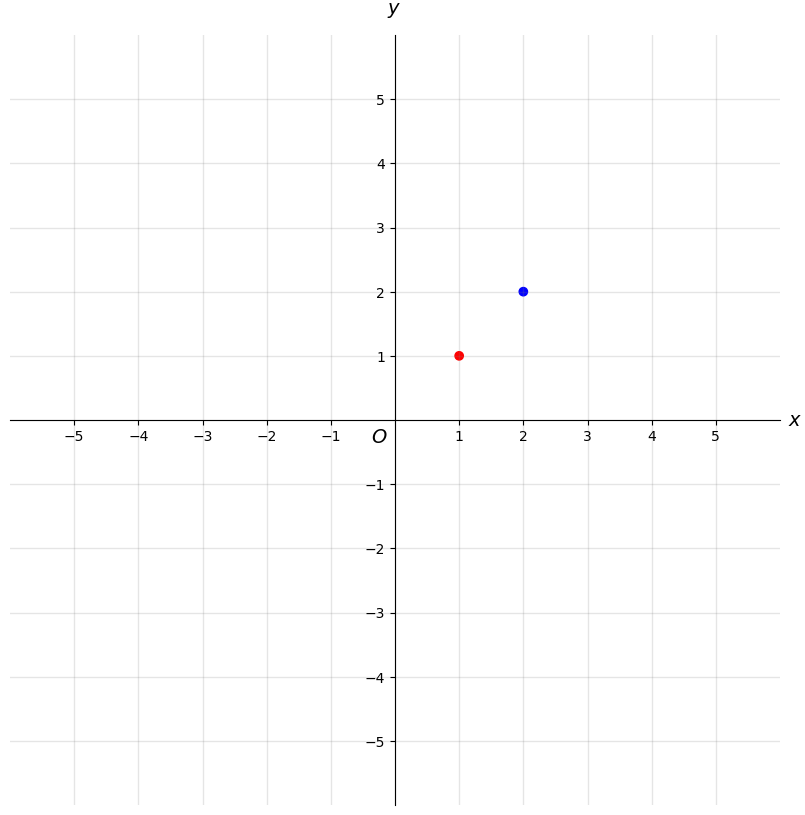

In [4]:
### Data visualization: Cartesian grid

# the code below makes a cartesian grid.
# you'll need to change the constants so that you get something you want out of it.
# it's just left here as an example of a working version
xmin, xmax, ymin, ymax = -5, 5, -5, 5
ticks = 1

fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('#ffffff')
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), aspect='equal')

# this creates our x-y grid lines...
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
# and this hides the edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
 
plt.text(0.49, 0.49, "$O$", ha='right', va='top', 
         transform=ax.transAxes,
         horizontalalignment='center', fontsize=14)

x_ticks = np.arange(xmin, xmax+1, ticks)
y_ticks = np.arange(ymin, ymax+1, ticks)

ax.set_xticks(x_ticks[x_ticks != 0])
ax.set_yticks(y_ticks[y_ticks != 0])
ax.set_xticks(np.arange(xmin, xmax+1), minor=True)
ax.set_yticks(np.arange(ymin, ymax+1), minor=True)
ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

# the easiest way to make plots
ax.scatter([1, 2], [1, 2], c=["r", "b"])

precip ratio_P values: [(2.1318445675433395e-08, 1989), (2.0820802859589094e-08, 1990), (2.1953884044023653e-08, 1991), (1.998329501873286e-08, 1992), (2.1667677430059484e-08, 1993), (2.1675544914501188e-08, 1994), (2.3411342198187413e-08, 1995), (1.9656830829717364e-08, 1996), (2.1898246771456797e-08, 1997), (2.102840923612348e-08, 1998), (2.1907757385974946e-08, 1999), (2.1363709024058153e-08, 2000), (2.3959399797490732e-08, 2001), (2.2118756604072587e-08, 2002), (2.186559733274862e-08, 2003), (2.089329242949134e-08, 2004), (2.191343284607683e-08, 2005), (2.2584481840226545e-08, 2006), (2.1189602961158016e-08, 2007), (2.1923007409441198e-08, 2008), (2.2915140007739865e-08, 2009), (2.0667966893483936e-08, 2010), (2.1450755838259283e-08, 2011), (2.290494016676803e-08, 2012), (2.2384686104715e-08, 2013), (2.308522262239876e-08, 2014), (2.103294427513447e-08, 2015), (2.362516404730286e-08, 2016), (2.038767554779497e-08, 2017), (2.2825012990779214e-08, 2018), (2.146969002581045e-08, 2019)

<Figure size 3840x2880 with 0 Axes>

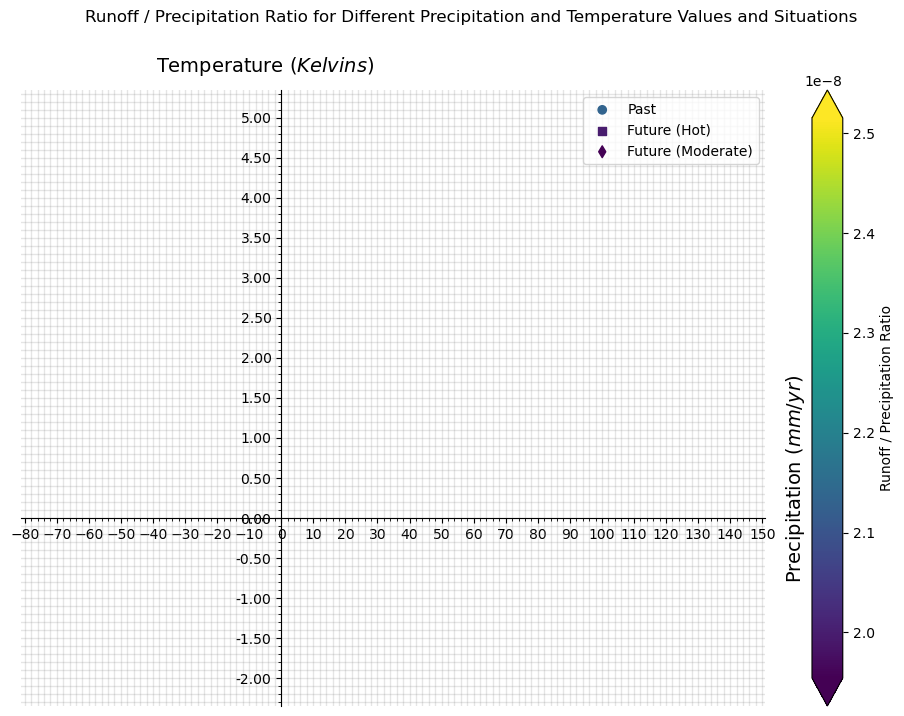

In [5]:
### Data visualization: Cartesian grid (example working code)
# the first step is to get an average over all space and time:
total_avg_qrunoff_P = annual_qrunoff_P.mean(dim=('lat', 'lon', 'year'))
total_avg_qrunoff_H = annual_qrunoff_H.mean(dim=('lat', 'lon', 'year'))
total_avg_qrunoff_M = annual_qrunoff_M.mean(dim=('lat', 'lon', 'year'))

total_avg_snow_P = annual_snow_P.mean(dim=('lat', 'lon', 'year'))
total_avg_snow_H = annual_snow_H.mean(dim=('lat', 'lon', 'year'))
total_avg_snow_M = annual_snow_M.mean(dim=('lat', 'lon', 'year'))

total_avg_rain_P = annual_rain_P.mean(dim=('lat', 'lon', 'year'))
total_avg_rain_H = annual_rain_H.mean(dim=('lat', 'lon', 'year'))
total_avg_rain_M = annual_rain_M.mean(dim=('lat', 'lon', 'year'))

total_avg_precip_P = annual_precip_P.mean(dim=('lat', 'lon', 'year'))
total_avg_precip_H = annual_precip_H.mean(dim=('lat', 'lon', 'year'))
total_avg_precip_M = annual_precip_M.mean(dim=('lat', 'lon', 'year'))

years_P = [x.item() for x in annual_qrunoff_P.year.values]
years_H = [x.item() for x in annual_qrunoff_H.year.values]
years_M = [x.item() for x in annual_qrunoff_M.year.values]
# now we need to loop over them by year to get the values by year.

# this value is the center of our coordinate grid.
# we define all points relative to these values.
x_origin, y_origin = total_precip_P.mean().values, total_temp_P.mean().values
#x_origin, y_origin = 750, 280

## HISTORICAL
# color
precip_ratio_values_P = [(annual_qrunoff_P.sel(year=x).mean(dim=('lat','lon')).values / annual_precip_P.sel(year=x).mean(dim=('lat','lon')).values).item()
           for x in years_P]
# y axis 
temp_values_P = [(annual_temp_P.sel(year=x).mean(dim=('lat','lon')).values).item() - y_origin
           for x in years_P]
# x axis
precip_values_P = [(annual_precip_P.sel(year=x).mean(dim=('lat','lon')).values).item() - x_origin
           for x in years_P]

## FUTURE HOT
# color
precip_ratio_values_H = [(annual_qrunoff_H.sel(year=x).mean(dim=('lat','lon')).values / annual_precip_H.sel(year=x).mean(dim=('lat','lon')).values).item()
           for x in years_H]
# y axis 
temp_values_H = [(annual_temp_H.sel(year=x).mean(dim=('lat','lon')).values).item() - y_origin
           for x in years_H]
# x axis
precip_values_H = [(annual_precip_H.sel(year=x).mean(dim=('lat','lon')).values).item() - x_origin
           for x in years_H]

## FUTURE MODERATE
# color
precip_ratio_values_M = [(annual_qrunoff_M.sel(year=x).mean(dim=('lat','lon')).values / annual_precip_M.sel(year=x).mean(dim=('lat','lon')).values).item()
           for x in years_M]
# y axis 
temp_values_M = [(annual_temp_M.sel(year=x).mean(dim=('lat','lon')).values).item() - y_origin
           for x in years_M]
# x axis
precip_values_M = [(annual_precip_M.sel(year=x).mean(dim=('lat','lon')).values).item() - x_origin
           for x in years_M]

all_heats = np.concatenate([
    precip_ratio_values_P,
    precip_ratio_values_H,
    precip_ratio_values_M
])

vmin, vmax = all_heats.min(), all_heats.max()

print(f"precip ratio_P values: {list(zip(precip_ratio_values_P,years_P))}")
print()
print(f"temp_P values: {list(zip(temp_values_P,years_P))}")
print()
print(f"precip_P values: {list(zip(precip_values_P,years_P))}")
print()
print(f"combined_P coords: {list(zip(precip_values_P, temp_values_P))}")
print()

print(f"precip ratio_H values: {list(zip(precip_ratio_values_H,years_H))}")
print()
print(f"temp_H values: {list(zip(temp_values_H,years_H))}")
print()
print(f"precip_H values: {list(zip(precip_values_H,years_H))}")
print()
print(f"combined_H coords: {list(zip(precip_values_H, temp_values_H))}")
print()

print(f"precip ratio_M values: {list(zip(precip_ratio_values_M,years_M))}")
print()
print(f"temp_M values: {list(zip(temp_values_M,years_M))}")
print()
print(f"precip_M values: {list(zip(precip_values_M,years_M))}")
print()
print(f"combined_M coords: {list(zip(precip_values_M, temp_values_M))}")
print()

#xmin, xmax = total_precip_P.max(), total_precip_P.min()

## cartesian grid
#xmin, xmax = (total_precip_P.max() - x_origin).values, (x_origin - total_precip_P.max()).values
#ymin, ymax = (total_temp_P.max() - y_origin).values, (y_origin - total_temp_P.max()).values

# We're defining it manually because using calculated values is extremely error-prone
xmin, xmax = -80, 150
#xmin, xmax = -150, 150
ymin, ymax = -2, 5
#ymin, ymax = -14, 14
ticks_x = 10
#ticks_x = 20
ticks_y = 0.5
#ticks_y = 4

plt.figure(dpi=600)
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#ffffff')
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-0.05*(ymax-ymin), ymax+0.05*(ymax-ymin)), aspect='auto')

# axes styling
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Precipitation $(mm/yr)$', size=14, labelpad=-120, x=1.04, rotation=-270)
ax.set_ylabel('Temperature $(Kelvins)$', size=14, labelpad=-21, y=1.02, rotation=0)
#ax.set_xlabel('$x$', size=14, labelpad=-24, x=1.02)
#ax.set_ylabel('$y$', size=14, labelpad=-21, y=1.02, rotation=0)
#plt.text(0.49, 0.49, "$O$", transform=ax.transAxes, ha='center', va='top', fontsize=14)

# grid ticks
ax.xaxis.set_major_locator(MultipleLocator(ticks_x))
ax.xaxis.set_minor_locator(MultipleLocator(ticks_x / 5))
ax.yaxis.set_major_locator(MultipleLocator(ticks_y))
ax.yaxis.set_minor_locator(MultipleLocator(ticks_y / 5))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))

ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

plt.suptitle("Runoff / Precipitation Ratio for Different Precipitation and Temperature Values and Situations")

# the easiest way to make plots
sc1 = ax.scatter(precip_values_P, temp_values_P, c=precip_ratio_values_P, label="Past",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="o")
sc2 = ax.scatter(precip_values_H, temp_values_H, c=precip_ratio_values_H, label="Future (Hot)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="s")
sc3 = ax.scatter(precip_values_M, temp_values_M, c=precip_ratio_values_M, label="Future (Moderate)",
                 vmin=vmin, vmax=vmax, cmap="viridis", marker="d")
plt.colorbar(sc1, label="Runoff / Precipitation Ratio", extend="both")
plt.legend()



In [6]:
### Data visualization: Cartesian grid (but for summertime, debugigng)

## REGIONAL

os.makedirs("runoff_ratio_debug", exist_ok=True)

# Regional testing
magic = 2

region_dic = {1:"West Coast",
              2:"Aleutians",
              3:"Central Interior",
              4:"Northern Slope",
              5:"NE Interior",
              6:"SE Interior",
              7:"Cook Inlet",
              8:"NW Gulf",
              9:"Bristol Bay",
              10:"North Panhandle",
              11:"NE Gulf",
              12:"Central Panhandle",
              13:"South Panhandle"}

## shadowing ALL the variables with filtered ones
total_qrunoff_P = total_qrunoff_P.where(model_grid.OBJECTID.values == magic)
total_qrunoff_H = total_qrunoff_H.where(model_grid.OBJECTID.values == magic)
total_qrunoff_M = total_qrunoff_M.where(model_grid.OBJECTID.values == magic)

total_temp_P = total_temp_P.where(model_grid.OBJECTID.values == magic)
total_temp_H = total_temp_H.where(model_grid.OBJECTID.values == magic)
total_temp_M = total_temp_M.where(model_grid.OBJECTID.values == magic)

total_precip_P = total_precip_P.where(model_grid.OBJECTID.values == magic)
total_precip_H = total_precip_H.where(model_grid.OBJECTID.values == magic)
total_precip_M = total_precip_M.where(model_grid.OBJECTID.values == magic)

# important helper function to get a summer season
def summerizer(ds, dataset_name, scale_by_time=True):
    """returns summer totals (may–aug) per season_year; optionally scaled by number of seconds"""
    mjja = ds.sel(time=ds.time.dt.month.isin([5, 6, 7, 8]))

    def get_season_year(time):
        return xr.DataArray(time.dt.year, dims='time')

    season_years = get_season_year(mjja.time).astype('int32')
    mjja.coords['season_year'] = season_years

    def get_seconds_per_summer(season_years):
        years = np.unique(season_years.values)
        starts = pd.to_datetime([f"{y}-05-01" for y in years])
        ends = pd.to_datetime([f"{y}-09-01" for y in years])
        durations = (ends - starts).days * 86400
        return xr.DataArray(durations, dims='season_year', coords={'season_year': years})

    seconds_per_year = get_seconds_per_summer(season_years)

    def groupby_reducer(ds):
        grouped = ds.groupby('season_year').mean(dim=('lat', 'lon', 'time'))
        grouped = grouped * seconds_per_year if scale_by_time else grouped
        grouped.name = dataset_name
        return grouped

    return cache_xarray(groupby_reducer, mjja, name_hint=dataset_name)

# years value we'll use later
years_P = [x.item() for x in summerizer(total_qrunoff_P, f"summerized_qrunoff_P_{magic}").season_year.values]
years_H = [x.item() for x in summerizer(total_qrunoff_H, f"summerized_qrunoff_H_{magic}").season_year.values]
years_M = [x.item() for x in summerizer(total_qrunoff_M, f"summerized_qrunoff_M_{magic}").season_year.values]

# this value is the center of our coordinate grid.
# we define all points relative to these values.
x_origin = summerizer(total_precip_P, f"summerized_precip_P_{magic}").mean().values
y_origin = summerizer(total_temp_P, f"summerized_temp_P_{magic}").mean().values

print(f"x-origin: {x_origin}, y-origin: {y_origin}")

## HISTORICAL
# color
precip_ratio_values_P = [(summerizer(total_qrunoff_P, f"summerized_qrunoff_P_{magic}").sel(season_year=x) / summerizer(total_precip_P, f"summerized_precip_P_{magic}").sel(season_year=x)).item()
                         for x in years_P]
# y axis 
temp_values_P = [(summerizer(total_temp_P, f"summerized_temp_P_{magic}").sel(season_year=x)).item() - y_origin
                 for x in years_P]
# x axis
precip_values_P = [(summerizer(total_precip_P, f"summerized_precip_P_{magic}").sel(season_year=x)).item() - x_origin
                   for x in years_P]
print("historical (P) done")

## HISTORICAL-DEBUG
# color
precip_ratio_values_debug_P = summerizer(total_qrunoff_P, f"summerized_qrunoff_P_{magic}").values / summerizer(total_precip_P, f"summerized_precip_P_{magic}").values
print(f"sanity test: is debug and real equal (precipitation ? {precip_ratio_values_P == precip_ratio_values_debug_P}")

# runoff
runoff_values_debug_P = [(summerizer(total_qrunoff_P, f"summerized_qrunoff_P_{magic}").sel(season_year=x)).item()
                         for x in years_P]
# y axis 
temp_values_debug_P = [(summerizer(total_temp_P, f"summerized_temp_P_{magic}").sel(season_year=x)).item()
                       for x in years_P]
# x axis
precip_values_debug_P = [(summerizer(total_precip_P, f"summerized_precip_P_{magic}").sel(season_year=x)).item()
                         for x in years_P]
print("historical (P-DEBUG) done")

## FUTURE HOT
# color
precip_ratio_values_H = [(summerizer(total_qrunoff_H, f"summerized_qrunoff_H_{magic}").sel(season_year=x).values / summerizer(total_precip_H, f"summerized_precip_H_{magic}").sel(season_year=x).values).item()
                         for x in years_H]

# y axis 
temp_values_H = [(summerizer(total_temp_H, f"summerized_temp_H_{magic}").sel(season_year=x).values).item() - y_origin
                 for x in years_H]
# x axis
precip_values_H = [(summerizer(total_precip_H, f"summerized_precip_H_{magic}").sel(season_year=x).values).item() - x_origin
                   for x in years_H]
print("future (H) done")

## FUTURE HOT-DEBUG
# color
precip_ratio_values_debug_H = summerizer(total_qrunoff_H, f"summerized_qrunoff_H_{magic}").values / summerizer(total_precip_H, f"summerized_precip_H_{magic}").values
print(f"sanity test: is debug and real equal (precipitation H)? {precip_ratio_values_H == precip_ratio_values_debug_H}")

# runoff
runoff_values_debug_H = [(summerizer(total_qrunoff_H, f"summerized_qrunoff_H_{magic}").sel(season_year=x).values).item()
                         for x in years_H]
# y axis 
temp_values_debug_H = [(summerizer(total_temp_H, f"summerized_temp_H_{magic}").sel(season_year=x).values).item()
                       for x in years_H]
# x axis
precip_values_debug_H = [(summerizer(total_precip_H, f"summerized_precip_H_{magic}").sel(season_year=x).values).item()
                         for x in years_H]
print("future (H-DEBUG) done")

## FUTURE MODERATE
# color
precip_ratio_values_M = [(summerizer(total_qrunoff_M, f"summerized_qrunoff_M_{magic}").sel(season_year=x).values / summerizer(total_precip_M, f"summerized_precip_M_{magic}").sel(season_year=x).values).item()
           for x in years_M]
# y axis 
temp_values_M = [(summerizer(total_temp_M, f"summerized_temp_M_{magic}").sel(season_year=x).values).item() - y_origin
           for x in years_M]
# x axis
precip_values_M = [(summerizer(total_precip_M, f"summerized_precip_M_{magic}").sel(season_year=x).values).item() - x_origin
           for x in years_M]
print("future (M) done")

## FUTURE MODERATE-DEBUG
# color
precip_ratio_values_debug_M = summerizer(total_qrunoff_M, f"summerized_qrunoff_M_{magic}").values / summerizer(total_precip_M, f"summerized_precip_M_{magic}").values
print(f"sanity test: is debug and real equal (precipitation M)? {precip_ratio_values_M == precip_ratio_values_debug_M}")

# runoff
runoff_values_debug_M = [(summerizer(total_qrunoff_M, f"summerized_qrunoff_M_{magic}").sel(season_year=x).values).item()
                         for x in years_M]
# y axis 
temp_values_debug_M = [(summerizer(total_temp_M, f"summerized_temp_M_{magic}").sel(season_year=x).values).item()
                       for x in years_M]
# x axis
precip_values_debug_M = [(summerizer(total_precip_M, f"summerized_precip_M_{magic}").sel(season_year=x).values).item()
                         for x in years_M]
print("future (M-DEBUG) done")

## Debugging symbols
log_file = open(f"runoff_ratio_debug/plot-{region_dic[magic]}-MJJA.log.txt", 'w')

log_file.write(f"######## Data log for {region_dic[magic]}\n")

log_file.write("#### HISTORICAL\n")
log_file.write(f"precip ratio_P values: {list(zip(precip_ratio_values_debug_P,years_P))}\n")
log_file.write(f"temp_P values: {list(zip(temp_values_debug_P,years_P))}\n")
log_file.write(f"precip_P values: {list(zip(precip_values_debug_P,years_P))}\n")

log_file.write("#### FUTURE (HOT)\n")
log_file.write(f"precip ratio_H values: {list(zip(precip_ratio_values_debug_H,years_H))}\n")
log_file.write(f"temp_H values: {list(zip(temp_values_debug_H,years_H))}\n")
log_file.write(f"precip_H values: {list(zip(precip_values_debug_H,years_H))}\n")

log_file.write("#### FUTURE (MODERATE)\n")
log_file.write(f"precip ratio_M values: {list(zip(precip_ratio_values_debug_M,years_M))}\n")
log_file.write(f"temp_M values: {list(zip(temp_values_debug_M,years_M))}\n")
log_file.write(f"precip_M values: {list(zip(precip_values_debug_M,years_M))}\n")

log_file.close()

x-origin: 439.047856438397, y-origin: 277.27508544921875
historical (P) done
sanity test: is debug and real equal (precipitation ? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
historical (P-DEBUG) done
future (H) done
sanity test: is debug and real equal (precipitation H)? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
future (H-DEBUG) done
future (M) done
sanity test: is debug and real equal (precipitation M)? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
future (M-DEBUG) done


In [7]:
summerizer(total_qrunoff_P, "summerized_qrunoff_P_2").values

array([320.83132077, 651.73369905, 456.82338215, 611.9994679 ,
       579.92203647, 647.36579689, 531.58546061, 565.24206083,
       423.9608124 , 641.49113899, 667.60185943, 753.67734495,
       619.10410366, 701.82682278, 568.34538305, 704.75466033,
       568.75318486, 573.94620135, 456.6667643 , 660.00950849,
       707.50094333, 592.00171502, 654.39716906, 691.77119122,
       777.78234396, 435.63110403, 548.70807161, 686.94460869,
       518.94971329, 538.28956294, 528.15421131, 486.64124056,
       647.27617947])

In [8]:
summerizer(total_precip_P, "summerized_precip_P_2").values

array([406.69163555, 438.83966294, 453.88487403, 358.7122149 ,
       497.55859893, 463.72995491, 408.85985139, 503.15106633,
       310.81955071, 535.25513556, 398.46604744, 418.01080318,
       357.76349965, 432.31560735, 468.09325634, 510.62615686,
       483.38037261, 390.52230186, 340.7842456 , 429.01124518,
       517.47620646, 459.81682831, 622.0726518 , 403.56341531,
       457.62932037, 288.1509048 , 471.37643199, 442.03422636,
       440.29816909, 518.70529511, 425.4841926 , 339.60228536,
       495.8932536 ])

In [9]:
summerizer(total_temp_P, "summerized_temp_P_2", scale_by_time=False).values

array([280.1672 , 277.243  , 276.5425 , 276.6721 , 277.4117 , 276.5336 ,
       276.3435 , 277.57806, 277.75793, 276.8912 , 276.34418, 276.34778,
       276.97632, 277.7184 , 278.09558, 277.861  , 277.35352, 276.93552,
       276.33716, 276.1939 , 277.04144, 275.90747, 276.56796, 275.64886,
       277.01   , 278.16733, 277.6298 , 278.6524 , 277.48532, 277.70703,
       278.37378, 278.45764, 278.12476], dtype=float32)

In [10]:
summerizer(total_qrunoff_P, "summerized_qrunoff_P_2").values / summerizer(total_precip_P, "summerized_precip_P_2").values

array([0.78888104, 1.48512943, 1.00647413, 1.70610156, 1.16553515,
       1.39599737, 1.30016547, 1.12340428, 1.36400948, 1.19847732,
       1.67542972, 1.80300925, 1.73048426, 1.62341311, 1.21417127,
       1.38017736, 1.17661622, 1.46968867, 1.34004658, 1.53844338,
       1.36721444, 1.28747292, 1.05196261, 1.71415734, 1.69959028,
       1.51181585, 1.16405496, 1.55405298, 1.17863246, 1.03775606,
       1.24130161, 1.43297399, 1.30527321])

In [11]:
def winterizer(ds, dataset_name, scale_by_time=True):
    """returns winter totals (dec–mar) per season_year; optionally scaled by number of seconds"""
    djfm = ds.sel(time=ds.time.dt.month.isin([12, 1, 2, 3]))

    def get_season_year(time):
        month = time.dt.month
        year = time.dt.year
        return xr.DataArray(year.where(month != 12, year + 1), dims='time')

    season_years = get_season_year(djfm.time).astype('int32')
    djfm.coords['season_year'] = season_years

    def get_seconds_per_winter(season_years):
        years = np.unique(season_years.values)
        starts = pd.to_datetime([f"{y-1}-12-01" for y in years])
        ends = pd.to_datetime([f"{y}-04-01" for y in years])
        durations = (ends - starts).days * 86400
        return xr.DataArray(durations, dims='season_year', coords={'season_year': years})

    seconds_per_year = get_seconds_per_winter(season_years)

    def groupby_reducer(ds):
        grouped = ds.groupby('season_year').mean(dim=('lat', 'lon', 'time'))
        grouped = grouped * seconds_per_year if scale_by_time else grouped
        grouped.name = dataset_name
        return grouped

    return cache_xarray(groupby_reducer, djfm, name_hint=dataset_name)

In [12]:
winterizer(total_temp_P, "winterized_temp_P_2", scale_by_time=False).values

array([271.1485 , 271.5107 , 270.8521 , 271.54538, 272.53812, 271.22195,
       272.0556 , 271.88013, 269.70267, 270.74048, 269.64606, 272.72998,
       270.51315, 272.75305, 272.35275, 273.02344, 270.57544, 271.0562 ,
       270.50882, 271.07864, 271.12848, 272.03854, 270.10226, 270.92163,
       272.99365, 273.24164, 272.70218, 271.93347, 273.68176, 273.43378,
       271.97604, 272.57782], dtype=float32)

In [13]:
winterizer(total_qrunoff_P, "winterized_qrunoff_P_2").values

array([241.99844017, 422.56099099, 212.47702312, 431.61354039,
       356.70077407, 340.80424493, 341.00790694, 311.56697753,
       175.20790084, 361.2744948 , 211.57233581, 426.13901077,
       326.99001627, 393.28966514, 315.16610761, 432.76084042,
       272.78956012, 297.53042764, 349.55814534, 340.55102197,
       308.38643944, 315.90268846, 321.72447704, 303.12171823,
       515.67340587, 328.00773826, 326.95553459, 304.10637062,
       407.07213634, 480.29502549, 354.31319901, 406.55861632])

In [14]:
winterizer(total_precip_P, "winterized_precip_P_2").values

array([707.13745581, 621.93694606, 528.64826855, 704.54779663,
       646.64683579, 631.88612075, 581.77034764, 545.98067146,
       513.92526232, 696.90858729, 701.50493821, 831.88927614,
       785.2725964 , 658.81378411, 663.39717116, 727.80391735,
       590.6167126 , 595.39071451, 749.48365982, 660.67944928,
       555.93969666, 527.14511304, 769.6282146 , 698.72496184,
       743.68363596, 543.28296084, 737.34791921, 564.44868007,
       653.99014929, 750.63049465, 677.42197188, 722.80632011])

In [15]:
winterizer(total_qrunoff_P, "winterized_qrunoff_P_2").values / winterizer(total_precip_P, "winterized_precip_P_2").values

array([0.34222263, 0.67942738, 0.40192513, 0.61261073, 0.55161605,
       0.53934441, 0.58615553, 0.57065569, 0.34092097, 0.51839581,
       0.30159779, 0.51225448, 0.41640319, 0.59696636, 0.47507906,
       0.59461186, 0.4618724 , 0.49972299, 0.46639862, 0.51545575,
       0.55471203, 0.59927083, 0.41802583, 0.43382122, 0.69340427,
       0.6037512 , 0.44342098, 0.53876709, 0.62244383, 0.63985547,
       0.52303175, 0.56247241])

In [16]:
total_rain_P.sel(time="1989-07-01T00:00:00.000000000").mean(dim=('lat','lon')).values

array(2.2333275e-05, dtype=float32)

In [17]:
total_snow_P.sel(time="1989-07-01T00:00:00.000000000").mean(dim=('lat','lon')).values

array(2.783457e-06, dtype=float32)

In [18]:
(total_rain_P + total_snow_P).sel(time="1989-07-01T00:00:00.000000000").mean(dim=('lat','lon')).values

array(2.5116746e-05, dtype=float32)

In [19]:
total_precip_P.sel(time="1989-07-01T00:00:00.000000000").mean(dim=('lat','lon')).values

array(4.769426e-05, dtype=float32)